# Imports

In [1]:
# Standard Imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import torch
import os

# Ch 2 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from sklearn.metrics import accuracy_score

# Ch 3 Imports
import torchvision
from torchvision import transforms

# Now you can import your file just like any other library
import sys
sys.path.append('../Inside-Deep-Learning/')

from idlmam import *


In [2]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
elif torch.xpu.is_available():
   device = torch.device("xpu")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
else:
   device = torch.device("cpu")
   B = 1
   epochs = 5
   num_workers_data_loaders = 1

print(device)

xpu


In [3]:
train_data = torchvision.datasets.FashionMNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256)

In [4]:
W, H = 28, 28
D = 28*28
n = 128
C = 1
n_filters = 32
classes = 10

In [5]:
leak_rate = 0.1

## FC Models

In [ ]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), nn.Tanh(),
    *[nn.Sequential(nn.Linear(n, n),nn.Tanh()) for _ in range(5)],
    nn.Linear(n, classes),
)

fc_relu_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), nn.LeakyReLU(leak_rate),
    *[nn.Sequential(nn.Linear(n, n), nn.LeakyReLU(leak_rate))
     for _ in range(5)],
    nn.Linear(n, classes),
)

fc_prelu_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), nn.PReLU(),
    *[nn.Sequential(nn.Linear(n, n), nn.PReLU())
     for _ in range(5)],
    nn.Linear(n, classes),
)

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_xpu_results = train_network(fc_model, loss_func, train_loader,
 test_loader=test_loader, epochs=1,
 score_funcs={'Accuracy': accuracy_score}, device=torch.device("xpu"))

fc_cpu_results = train_network(fc_model, loss_func, train_loader,
 test_loader=test_loader, epochs=1,
 score_funcs={'Accuracy': accuracy_score}, device=torch.device("cpu"))

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, loss_func, train_loader,
 test_loader=test_loader, epochs=4,
 score_funcs={'Accuracy': accuracy_score}, device=device)

fc_relu_results = train_network(fc_relu_model, loss_func, train_loader,
 test_loader=test_loader, epochs=4,
 score_funcs={'Accuracy': accuracy_score}, device=device)

fc_prelu_results = train_network(fc_prelu_model, loss_func, train_loader,
 test_loader=test_loader, epochs=4,
 score_funcs={'Accuracy': accuracy_score}, device=device)

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results,
     label='Fully Connected')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_relu_results,
     label='FC ReLU')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_prelu_results,
     label='FC PReLU')

"Let's be explicit and tell Python we are finished so we can get back the GPU memory and avoid such annoyances:"

is it GPU?

In [ ]:
del fc_model
del fc_relu_model
del fc_prelu_model

## CNN Models

In [6]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3, pool_factor=0,
            batch_norm=False, leak=0.1, prelu=False):

    if out_filters is None:
        out_filters = in_filters

    padding=kernel_size//2

    # Choose norm type
    if batch_norm:
        norm = nn.BatchNorm2d(out_filters)
    else:
        norm = nn.LayerNorm([out_filters,
         W//(2**pool_factor), H//(2**pool_factor)])

    # Chose activation Layer
    if prelu:
        activation = nn.PReLU()
    else:
        activation = nn.LeakyReLU(leak)

    # Return Model
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        norm,
        activation
    )

In [ ]:
results = {}

In [ ]:
for BN in [False, True]:
    for prelu in [True, False]:
        model = nn.Sequential(
            cnnLayer(C, n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            nn.MaxPool2d((2,2)),

            cnnLayer(n_filters, 2*n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            nn.MaxPool2d((2,2)),

            cnnLayer(2*n_filters, 4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            cnnLayer(4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            nn.Flatten(),
            nn.Linear(D*n_filters//4, classes),
        )

        norm = "BN" if BN else "LN"
        activation = "PReLU" if prelu else "ReLU"
        name = f"CNN with BN, ReLU={prelu}"

        results[name] = train_network(model, loss_func, train_loader,
                                                            test_loader=test_loader, epochs=2,
                                                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
        del model

In [ ]:
for name in results.keys():
    sns.lineplot(x='epoch', y='test Accuracy', data=results[name],
     label=name)

# 2\. Write a for loop to train CNN models with 1 to 20 sets of hidden layers, once with BN layers and one without. How does BN impact the ability to learn deeper models?

In [7]:
results_ex2 = {}

In [37]:
def create_cnn_no_pool(D, C, classes, num_hidden_layers=0, n_filters=16, BN=True):
    # Input Layer
    sequential_layers = [
        cnnLayer(C, n_filters, batch_norm=BN),
    ]

    # Hidden Layers
    for layer in range(num_hidden_layers):
            sequential_layers.append( cnnLayer(n_filters, batch_norm=BN) )
    
    # Ouput Layer
    expected_size = D*n_filters
    sequential_layers.append( nn.Flatten() )
    sequential_layers.append( nn.Linear(expected_size, classes) )

    return nn.Sequential(*sequential_layers)


def create_cnn_with_pool(D, C, classes, num_hidden_layers=0, n_filters=16, BN=True):
    # Input Layer
    sequential_layers = [
        cnnLayer(C, n_filters, batch_norm=BN),
    ]

    # Hidden Layers
    count = 1
    count_pool = 0
    new_n_filters = n_filters
    for layer in range(num_hidden_layers):
        # cnnLayer(n_filters, 2*n_filters),
        if count == 0:
            sequential_layers.append( cnnLayer(new_n_filters//2, new_n_filters, batch_norm=BN) )
            count += 1

        # cnnLayer(n_filters),
        elif count == 1:
            sequential_layers.append( cnnLayer(new_n_filters, batch_norm=BN) )
            count += 1

        # cnnLayer(n_filters) + pooling
        elif count == 2:
            sequential_layers.append( cnnLayer(new_n_filters) )
            sequential_layers.append( nn.MaxPool2d((2,2)) )
            count = 0
            count_pool += 1
            new_n_filters *= (2 ** count_pool)

    # Ouput Layer
    expected_size = D*new_n_filters//(4**count_pool)
    print(D,new_n_filters,count_pool)
    sequential_layers.append( nn.Flatten() )
    sequential_layers.append( nn.Linear(expected_size, classes) )

    return nn.Sequential(*sequential_layers)

In [33]:
(784*32)//4

6272

In [38]:
model = create_cnn_with_pool(D, C, 10, num_hidden_layers=2)
print(model)
del model

784 32 1
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=10, bias=True)
)


In [39]:
model = create_cnn_no_pool(D, C, 10, num_hidden_layers=3)
print(model)
del model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=12544, out_features

Epoch: 100%|██████████| 2/2 [00:35<00:00, 17.73s/it]


<Axes: xlabel='epoch', ylabel='test Accuracy'>

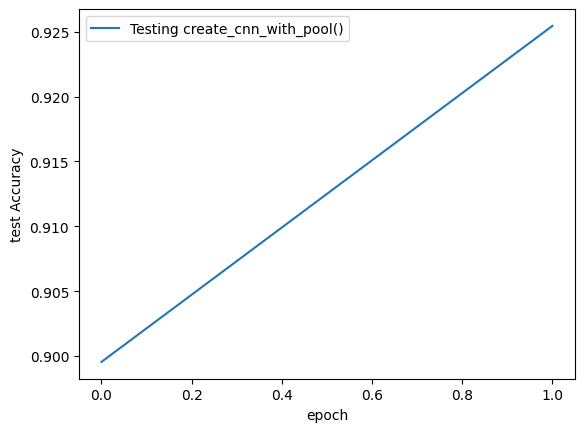

In [40]:
model = create_cnn_no_pool(D, C, 10, num_hidden_layers=2)
loss_func = nn.CrossEntropyLoss()

test_results = train_network(model, loss_func, train_loader,
                            test_loader=test_loader, epochs=2,
                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
del model

sns.lineplot(x='epoch', y='test Accuracy', data=test_results,
     label='Testing create_cnn_with_pool()')

In [ ]:
for i in range(1, 21):
    print(i)
    model = nn.Sequential(
            cnnLayer(C, n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            nn.MaxPool2d((2,2)),

            cnnLayer(n_filters, 2*n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            nn.MaxPool2d((2,2)),

            cnnLayer(2*n_filters, 4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            cnnLayer(4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            nn.Flatten(),
            nn.Linear(D*n_filters//4, classes),
        )
